##### 导入必要的包

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   torchtext.vocab import GloVe

In [2]:
from   torchtext.data import Field
from   torch.optim import lr_scheduler
%matplotlib inline

##### 数据预处理

In [3]:
data         = pd.read_csv("./PRSA_data_2010.1.1-2014.12.31.csv")
'''删除前24条PM2.5数值为NaN的条目并'''
'''使用前向填充的方法填充PM2.5的NaN'''
'''值，来近似保证数据的完整性与合理性'''
data         = data.iloc[24:].fillna(method='ffill')
'''合并多条时间数据(年月日)到一列当中'''
data['time'] = data.apply(lambda x : datetime.datetime(year=x['year'],month=x['month'],day=x['day'],hour=x['hour']),axis=1)
'''设置time为索引'''
data         = data.set_index('time')
'''删除年月日以及No列'''
data         = data.drop(columns=['year', 'month', 'day', 'hour','No'])
'''将风向数据独热编码化'''
data         = data.join(pd.get_dummies(data.cbwd))
'''删除年月日以及cbwd列'''
data         = data.drop(columns=['cbwd'])

seq_length   = 5*24  # 观测过去五天的特征数据
delay_length = 1*24  # 预测未来一天的特征数据
'''数据采样'''
data_        = []
for i in range(len(data)-seq_length-delay_length):
    data_.append(data.iloc[i:i+seq_length+delay_length])
data_        = np.array([df.values for df in data_],dtype=np.float32)
'''数据乱序'''
np.random.shuffle(data_)
'''获取训练数据以及目标值'''
x            = data_[:,:5*24,:]
y            = data_[:,-1,0]
'''切分数据集'''
split_b      = int(data_.shape[0]*0.8)
train_x      = x[:split_b]
train_y      = y[:split_b]
test_x       = x[split_b:]
test_y       = y[split_b:]
'''数据标准化'''
mean         = train_x.mean(axis=0)  #在每一列上取均值
std          = train_x.std(axis=0)   #在每一列上取方差
train_x      = (train_x-mean) / std
test_x       = (test_x-mean)  / std

##### 创建DataSet

In [4]:
class My_Dataset(torch.utils.data.Dataset):
    
    def __init__(self,features,labels):
        self.features = features
        self.labels   = labels
    
    def __getitem__(self,index):
        return self.features[index],self.labels[index]
    
    def __len__(self):
        return len(self.features)

In [5]:
train_ds = My_Dataset(train_x,train_y)
test_ds  = My_Dataset(test_x , test_y)
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl  = torch.utils.data.DataLoader(test_ds ,batch_size=128)

##### 构建模型

In [6]:
hidden_size = 64  # 设置64个隐藏层单元

In [7]:
class Net(nn.Module):
    def __init__(self,hidden_size):
        super(Net,self).__init__()
        self.rnn = nn.LSTM(train_x.shape[-1],hidden_size,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,128)
        self.fc2 = nn.Linear(128,1) # 回归问题 输出为1
    
    def forward(self,inputs):
        _,s_o = self.rnn(inputs) # s_o是每一个时间步的中间状态列表
        s_o   = s_o[-1]
        x     = self.fc1(s_o)
        x     = F.relu(x)
        x     = F.dropout(x)
        x     = self.fc2(x) # shape==（128X1） -> label shape 128
        return torch.squeeze(x)
    
    

In [8]:
model      = Net(hidden_size)
model      = model.to("cuda")
loss_fn    = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(),lr = 0.0001)
epochs     = 60
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

##### 训练模型

In [9]:
def fit(epoch, model, trainloader, testloader):
    total        = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred   = model(x)
        loss     = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total        += y.size(0)
            running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total        = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred   = model(x)
            loss     = loss_fn(y_pred, y)
            test_total        += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    print('\tepoch:\t\t', epoch, '\tloss:\t\t', str(round(epoch_loss, 2)).rjust(5),'\ttest_loss:\t\t', str(round(epoch_test_loss, 2)).rjust(5))
    return epoch_loss, epoch_test_loss

In [10]:
for epoch in range(epochs):
    epoch_loss,epoch_test_loss = fit(epoch,model,train_dl,test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

	epoch:		 0 	loss:		 121.75 	test_loss:		 65.73
	epoch:		 1 	loss:		 60.47 	test_loss:		 60.28
	epoch:		 2 	loss:		 57.84 	test_loss:		 58.89
	epoch:		 3 	loss:		 57.19 	test_loss:		  58.2
	epoch:		 4 	loss:		 56.71 	test_loss:		 57.69
	epoch:		 5 	loss:		 56.22 	test_loss:		 57.72
	epoch:		 6 	loss:		 55.66 	test_loss:		 57.55
	epoch:		 7 	loss:		 55.47 	test_loss:		 56.58
	epoch:		 8 	loss:		 54.39 	test_loss:		 57.07
	epoch:		 9 	loss:		 54.24 	test_loss:		  55.3
	epoch:		 10 	loss:		 53.73 	test_loss:		 55.05
	epoch:		 11 	loss:		 53.07 	test_loss:		  54.6
	epoch:		 12 	loss:		 52.68 	test_loss:		 53.95
	epoch:		 13 	loss:		 51.93 	test_loss:		 53.97
	epoch:		 14 	loss:		  51.8 	test_loss:		 53.15
	epoch:		 15 	loss:		 51.21 	test_loss:		 52.77
	epoch:		 16 	loss:		 51.09 	test_loss:		  53.4
	epoch:		 17 	loss:		 50.56 	test_loss:		 53.03
	epoch:		 18 	loss:		 50.58 	test_loss:		 51.45
	epoch:		 19 	loss:		 49.64 	test_loss:		 50.91
	epoch:		 20 	loss:		 50.32 	test_loss:		 51.29
	

##### 预测演示

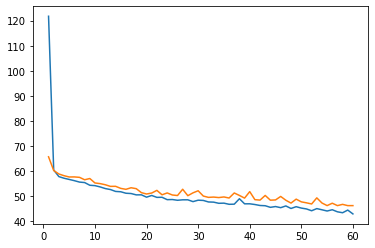

In [11]:
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.plot(range(1,len(test_loss )+1),test_loss ,label="test_loss" )

In [12]:
'''批量预测01'''
test_x.shape

(8732, 120, 11)

In [13]:
pred_test = model(torch.from_numpy(test_x).cuda())

In [14]:
pred_test.shape

torch.Size([8732])

In [15]:
pred_test[:5]

tensor([161.2150, 306.6635, 127.8636,  99.7120,  71.6993], device='cuda:0',
       grad_fn=<SliceBackward>)

In [16]:
'''批量预测02'''
result = []
for test_b,_ in test_dl:
    pred_b = model(test_b.cuda())
    result.append(pred_b.cpu().detach().numpy())#detach获取模型pred_b的值，忽略grad属性

In [17]:
result = np.concatenate(result)
print(result)

[169.09084  302.4623   160.94534  ...  63.218876 113.25458  107.49961 ]


In [18]:
'''单条预测'''
'''预测24h后 比如2015.1.1 23时 的PM2.5的值'''
data_last = data.iloc[-120:,:]  # 取最后120条数据
data_last.shape

(120, 11)

In [19]:
data_last = np.expand_dims(data_last.values,0)#在第0维增加数据 满足模型的条件
data_last.shape

(1, 120, 11)

In [20]:
'''数据归一化'''
data_last = (data_last-mean)/std

In [21]:
'''预测'''
pred_ = model(torch.from_numpy(data_last).float().cuda())

In [22]:
pred_

tensor(68.2217, device='cuda:0', grad_fn=<SqueezeBackward0>)